## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)

1.9.0+cu102
10.2


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=4b47b584df1445261744e8bbdb4d45ea96c2e801c8c9d0f6e5103e7882cd6156
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 277.9 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [ ]:
import numpy as np
np.random.seed(0)
import os, glob
import time
import h5py
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import ConcatDataset, Dataset, DataLoader, sampler, DistributedSampler
#from torch.utils.data import *
from sklearn.metrics import roc_curve, auc

## Optional for parsing argument 

In [ ]:
import argparse
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
parser = argparse.ArgumentParser()
#parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=50, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=64, help='Initial learning rate.') #100
parser.add_argument('--maxnodes', type=int, default=1000, help='max nodes.') #100
parser.add_argument('--lr', type=float, default=0.001, help='Initial learning rate.') #0.001
parser.add_argument('--dropout', type=float, default=0.3, help='Dropout rate (1 - keep probability).')
args = parser.parse_args([])
torch.backends.cudnn.benchmark = True

In [ ]:
BATCH_SZ = 64

granularity = 1
#channels = [0,1,2,3,4,5,6,7]
#channels = [0,3,5]
lr_init = 5.e-4
edgeconvblocks = 3
epochs = 1
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)

expt_name = 'Graphs_%d_RH1o100_ECAL+HCAL+Trk_lr%s_gamma0.5every10ep_epochs%d'%(edgeconvblocks, str(lr_init), epochs)#'ResNet_blocks%d_RH1o100_ECAL+HCAL+Trk_lr%s_gamma0.5every10ep_epochs%d'%(resblocks, str(lr_init), epochs)

In [ ]:
import torch
from torch_geometric.data import Data
class ParquetDataset(Dataset):
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        self.cols = None # read all columns
        #self.cols = ['X_jets.list.item.list.item.list.item','y'] 
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['X_jets'] = torch.tensor(np.float32(data['X_jets'])) 
        data['y'] = torch.tensor(np.float32(data['y']))
        data['m0'] = torch.tensor(np.float32(data['m0']))
        data['pt'] = torch.tensor(np.float32(data['pt']))
        data['X_jets'][data['X_jets'] < 1.e-3] = 0.
        # Preprocessing
        #data['nonzeroPixels'][data['nonzeroPixels'] < 1.e-3] = 0. # Zero-Suppression
        #data['nonzeroPixels'][-1,...] = 25.*data['nonzeroPixels'][-1,...] # For HCAL: to match pixel intensity distn of other layers
        #data['nonzeroPixels'] = data['nonzeroPixels']/100. # To standardize
        return dict(data)
    def __len__(self):
        return self.parquet.num_row_groups

In [ ]:
import torch_geometric
import torch
import torch.nn.functional as F
from torch.nn import Linear as Lin, Sequential as Seq, ReLU, AvgPool1d, Dropout, Softmax, Sigmoid, BatchNorm1d
from torch_geometric.nn import EdgeConv, DynamicEdgeConv, BatchNorm, avg_pool_x, knn_graph, EdgePooling, DenseSAGEConv, dense_diff_pool, dense_mincut_pool, SAGEConv, max_pool_x, SAGPooling, JumpingKnowledge, global_mean_pool as gap, global_max_pool as gmp
#from torch_cluster import knn_graph

class PointNet(torch.nn.Module):
    def __init__(self, in_channels):
        super(PointNet, self).__init__()
        self.edgeConv0 = EdgeConv(ShortcutModule(in_channels, 32), aggr='mean')
        
        self.edgeConvBlock1 = SAGEConv(in_channels, 512, normalize=True)
        self.edgePool1 = SAGPooling(512, GNN=torch_geometric.nn.conv.SAGEConv, nonlinearity=ReLU())
  
        self.edgeConvBlock2 = SAGEConv(512, 512, normalize=True)
        self.edgePool2 = SAGPooling(512, GNN=torch_geometric.nn.conv.SAGEConv, nonlinearity=ReLU())
        
        self.edgeConvBlock3 = SAGEConv(512, 512, normalize=True)
        self.edgePool3 = SAGPooling(512, GNN=torch_geometric.nn.conv.SAGEConv, nonlinearity=ReLU())
        self.JKNet = JumpingKnowledge(mode='max')
        self.edgeConvBlock4 = SAGEConv(512, 512, normalize=True)
        self.dropout = Dropout(0.1)
        self.poolit1=Lin(128,250)
        self.poolit2=Lin(256,50)
        
        self.dense1 = Seq(Lin(1024,1))
        self.dense2 = Seq(Lin(1024,1),ReLU())
        self.softmax = Softmax()
        self.bano1 = BatchNorm(512)
        self.bano2 = BatchNorm(512)
        self.bano3 = BatchNorm(512) 
        self.bano4 = BatchNorm(512)  
        self.sigmoid = Sigmoid()
        self.relu = ReLU()

    def forward(self, gra, lengs, adj, pos, nodeCount):
        
        x1 = self.bano1(self.relu(self.edgeConvBlock1(gra, edge_index=adj))) 
        x1_readout = torch.cat([gap(x1, batch=lengs),gmp(x1, batch=lengs)], dim=1)
        
        x2 = self.bano2(self.relu(self.edgeConvBlock2(x1, edge_index=adj)))
        x2_readout = torch.cat([gap(x2, batch=lengs),gmp(x2, batch=lengs)], dim=1)

        x3 = self.bano3(self.relu(self.edgeConvBlock3(x2, edge_index=adj)))
        x3_readout = torch.cat([gap(x3, batch=lengs),gmp(x3, batch=lengs)], dim=1)

        x = x1_readout + x2_readout + x3_readout
        
        x = self.dense1(x)
       
        x = self.sigmoid(x)

        return x, x3

In [ ]:
num_node_features = 10
model1 = PointNet(num_node_features)
model1.cuda()

optimizer = optim.Adam(model1.parameters(), lr=lr_init)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.5)

In [ ]:
import torch
from torch_geometric.data import Data
from torch.nn.functional import pad
MAX_NODES = 5000
class TrainParquetDataset(Dataset):
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        self.cols = None # read all columns
        #self.cols = ['X_jets.list.item.list.item.list.item','y'] 
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data_out = {}
        num_nodes = torch.tensor(data['coords0']).shape[1]
        data_out['num_nodes'] = torch.tensor(num_nodes)
        data_out['ECAL'] = pad(torch.tensor(data['ECAL'][0])/100.,(0,MAX_NODES-num_nodes),'constant')
        data_out['y'] = torch.tensor(data['y'])
        data_out['pT'] = pad(torch.tensor(data['pT'][0])/10.,(0,MAX_NODES-num_nodes),'constant')
        data_out['pT_jet'] = torch.tensor(data['pT_jet'])
        data_out['HCAL'] = pad(torch.tensor(data['HCAL'][0])/500.,(0,MAX_NODES-num_nodes),'constant')
        data_out['m0'] = torch.tensor(data['m0'][0])
        data_out['dz'] = pad(torch.tensor(data['dz'][0])/2.5,(0,MAX_NODES-num_nodes),'constant')
        data_out['d0'] = pad(torch.tensor(data['d0'][0])/2.,(0,MAX_NODES-num_nodes),'constant')
        data_out['BPIX1'] = pad(torch.tensor(data['BPIX1'][0])/8.,(0,MAX_NODES-num_nodes),'constant')
        data_out['BPIX2'] = pad(torch.tensor(data['BPIX2'][0])/10.,(0,MAX_NODES-num_nodes),'constant')
        data_out['BPIX3'] = pad(torch.tensor(data['BPIX3'][0])/13.,(0,MAX_NODES-num_nodes),'constant')
        data_out['coords0'] = pad(torch.tensor(data['coords0'][0]),(0,MAX_NODES-num_nodes),'constant')
        data_out['coords1'] = pad(torch.tensor(data['coords1'][0]),(0,MAX_NODES-num_nodes),'constant')
        data_out['edge_index_from'] = pad(torch.tensor(data['edge_index_from'][0]),(0,16*(MAX_NODES-num_nodes)),'constant')
        data_out['edge_index_to'] = pad(torch.tensor(data['edge_index_to'][0]),(0,16*(MAX_NODES-num_nodes)),'constant')
      
        return dict(data_out)
    def __len__(self):
        return self.parquet.num_row_groups

In [ ]:
trainDecays = glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_0_to_6399.parquet')
trainDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_6400_to_12799.parquet'))
trainDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_12800_to_19199.parquet'))
trainDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_19200_to_25599.parquet'))
trainDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_25600_to_31999.parquet'))
trainDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_32000_to_38399.parquet'))
trainDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_38400_to_44799.parquet'))
trainDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_44800_to_51199.parquet'))
trainDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_51200_to_57599.parquet'))
trainDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_57600_to_63999.parquet'))
#trainDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_96000_to_102399.parquet'))
assert len(trainDecays) == 10, "len(decays) = %d"%(len(trainDecays))

print(">> Input files:",trainDecays)
dset_train = ConcatDataset([TrainParquetDataset(d) for d in trainDecays])
idxs = np.random.permutation(6400*5)
train_sampler = sampler.SubsetRandomSampler(idxs[:(6400*5)])
train_loader = DataLoader(dataset=dset_train, batch_size=BATCH_SZ, num_workers=0, sampler=train_sampler, pin_memory=True)

>> Input files: ['./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_0_to_6399.parquet', './data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_6400_to_12799.parquet', './data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_12800_to_19199.parquet', './data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_19200_to_25599.parquet', './data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_25600_to_31999.parquet', './data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_32000_to_38399.parquet', './data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_38400_to_44799.parquet', './data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_44800_to_51199.parquet', './data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_51200_to_57599.parquet', './data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_sa

In [ ]:
printm()

Gen RAM Free: 10.1 GB  | Proc size: 6.4 GB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [ ]:
## generate list to count nodes for each graph
def nodeCounter(samples):
    inds=[]
    for k in samples:
        inds.append(k['x'].shape[0])
    return inds

def ref(bsize,nodeC,i1,i2):
  maxC=np.max(np.array(nodeC))
  maxC=args.maxnodes#maxC + (4 - maxC % 4) ##max num of nodes 1161%4
  refMat=np.zeros((bsize,maxC)) ## matrix of zeros
  for pi in range(i1,i2):##10
    refMat[pi,:nodeC[pi]]=1 ## fill ones 
  return refMat,maxC

def assigner(nodelist):
  fin=[]
  countit=0
  for m in nodelist:
      fin.append(np.repeat(countit,m))
      countit+=1
  return np.array(fin)


## Graph generation

In [ ]:
import torch_geometric.transforms
from torch_geometric.nn import knn_graph
import torch_geometric.data
import torch 
from torch_geometric.data import Data
import numpy as np

def graphCloud(batch_data, start_idx, end_idx, granularity=1):
  graphs = []
  num_nodes = batch_data['num_nodes']
  for i in range(start_idx, end_idx):
    data={}
    data['BPIX1'] = torch.unsqueeze(batch_data['BPIX1'][i][:num_nodes[i]].cuda(),dim=1)
    data['BPIX2'] = torch.unsqueeze(batch_data['BPIX2'][i][:num_nodes[i]].cuda(),dim=1)
    data['BPIX3'] = torch.unsqueeze(batch_data['BPIX3'][i][:num_nodes[i]].cuda(),dim=1)
    data['ECAL'] = torch.unsqueeze(batch_data['ECAL'][i][:num_nodes[i]].cuda(),dim=1)
    data['pT'] = torch.unsqueeze(batch_data['pT'][i][:num_nodes[i]].cuda(),dim=1)
    data['dz'] = torch.unsqueeze(batch_data['dz'][i][:num_nodes[i]].cuda(),dim=1)
    data['d0'] = torch.unsqueeze(batch_data['d0'][i][:num_nodes[i]].cuda(),dim=1)
    data['HCAL'] = torch.unsqueeze(batch_data['HCAL'][i][:num_nodes[i]].cuda(),dim=1)
    data['coords0'] = torch.unsqueeze(batch_data['coords0'][i][:num_nodes[i]].cuda(),dim=1)
    data['coords1'] = torch.unsqueeze(batch_data['coords1'][i][:num_nodes[i]].cuda(),dim=1)
    data['edge_index_from'] = torch.unsqueeze(batch_data['edge_index_from'][i][:(num_nodes[i]*16)].cuda(),dim=0)
    data['edge_index_to'] = torch.unsqueeze(batch_data['edge_index_to'][i][:(num_nodes[i]*16)].cuda(),dim=0)
    feats = torch.cat((data['coords0'],data['coords1'],data['pT'],data['ECAL'],data['HCAL'],data['d0'],data['dz'],data['BPIX1'],data['BPIX2'],data['BPIX3']), dim=1)
    feats = torch.unique(feats,dim=0)
    edge_index = torch.cat((data['edge_index_from'],data['edge_index_to']),dim=0)
    graph = Data(x=feats, pos=torch.cat((data['coords0'],data['coords1']),dim=1), edge_index=edge_index)
    graphs.append(graph)
  
  return graphs

In [ ]:
# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()


def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(14, 14))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black') 
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=30, color='green', zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000) 
       plt.scatter(pos[mask, 0],  pos[mask, 1], s=50, zorder=1000)
    plt.axis('on')
    plt.show()

In [ ]:
import gc 
gc.collect() 
torch.cuda.empty_cache()

In [ ]:
printm()

Gen RAM Free: 9.7 GB  | Proc size: 5.4 GB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


## Train the Graph Neural Network Model

In [ ]:
from torch_geometric.utils import to_dense_batch, to_dense_adj
# MAIN #
torch.backends.cudnn.enabled=True
#eval_step = 1000
print_step = 10
roc_auc_best = 0.5

count=0
c1,c2=0, BATCH_SZ
t = time.time()
max_nodes = args.maxnodes
start_epoch = 0
running_loss_list = []
acc_list = []
sum_list=[]
max_samples=3200/BATCH_SZ/print_step
BATCH_SZ = 64
USE_PREVIOUS = True

if (USE_PREVIOUS):
  model1 = PointNet(num_node_features)
  model1.cuda()
  #model1 = torch.nn.DataParallel(model1, device_ids=[0])
  optimizer = optim.Adam(model1.parameters(), lr=0.001)
  lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.5)
  checkpoint = torch.load('MODELS/SAGEConv_trial1_0-1-2-3-4_channels_256-512-1024-layers_without_SAGPooling+readout.pt')
  #checkpoint = torch.load('MODELS/PointNet_0-3-5_channels_1*3200_normalised_clip5_samples.pt')
  model1.load_state_dict(checkpoint['model_state_dict'])
  #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  running_loss_list = checkpoint['running_loss']
  acc_list = checkpoint['accuracy']
  epochs = checkpoint['total_epochs']

  print('Prevsious durring Trainng:')
  print(' >> Epochs finished earlier : ',start_epoch,' out of ',epochs,'. Continuing remaining training.')
  print(' >> Batch Loss: ', loss)
  print(' >> Running Loss: ',running_loss_list)
  print(' >> Accuracy: ',acc_list )
optimizer = optim.Adam(model1.parameters(), lr=0.001)
print(' >> Optimizer: ',optimizer)
print(' >> lr_scheduler: ',lr_scheduler)

print(">> Training <<<<<<<<")
#f = open('%s.log'%(expt_name), 'w')
epochs = 3
#epochs=23
start_epoch = 0
MAX_NODES=5000

for e in range(start_epoch, epochs):

    epoch = e+1
    s = '>> Epoch %d <<<<<<<<'%(epoch)
    print(s)
    #f.write('%s\n'%(s))
    running_loss, acc_ = 0., 0.
    # Run training
    
    model1.train()
    now = time.time()
    batch_data = []
    true_y=[]
    train_step=0
    gc.collect() 
    torch.cuda.empty_cache()

    for i, data in enumerate(train_loader):
        #print(i, logits)
        #if i>=max_samples:
        #  break
        #batch_data.append(data)
        #true_y.append(int(data['y'].item()))
        #if (i+1)%BATCH_SZ!=0 and (i+1)<max_samples:
        # continue
        train_step+=1
        #print("Step: ",train_step)
        if len(data['y'])<c2 or len(data['y'])<BATCH_SZ:
          print(" >> Last Batch with less samples than Batch size: Found ", len(data['y']), "samples but Batch size is ",c2)
          c2 = len(data['y'])
        else:
          c2 = BATCH_SZ
        
        
        rawGraph = graphCloud(data,c1,c2) ##Generating graphs from raw data
        nodeCount = nodeCounter(rawGraph)
        lengs=torch.LongTensor(np.hstack(assigner(np.array(nodeCount[c1:c2])))).cuda()

        compress = torch_geometric.data.Batch.from_data_list(rawGraph)

        gra = compress.x.clone()
        pos = compress.pos.clone()
        adj = compress.edge_index.clone()
        gra.cuda()
        pos.cuda()
        lengs.cuda()
        adj.cuda()
        '''
        whole,mask=to_dense_batch(gra, lengs, fill_value=0, max_num_nodes=MAX_NODES)#refMat.shape[1])
        wholeAdj=to_dense_adj(adj, lengs, edge_attr=None, max_num_nodes=MAX_NODES)#refMat.shape[1]).cuda()

        whole=whole.cuda()
        mask=mask.cuda()
        lengs=lengs.cuda()
        wholeAdj.cuda()
        '''
        
        model1.zero_grad()
        #print('conv1.bias.grad before backward')
        #print(model1.edgeConv0.nn.nn[0].bias)
        optimizer.zero_grad()
        #print(model1(gra,lengs).shape)
        #logits = model1(gra,lengs,pos)
        logits, stage1_graph = model1(gra, lengs, adj, pos, nodeCount)
        #print(logits.shape)
        true_y = torch.squeeze(data['y'])#torch.squeeze(data['y'].long())
        #loss = torch.nn.BCELoss()(torch.squeeze(logits), true_y.to('cuda'))#F.cross_entropy(logits, true_y.to('cuda'))
        loss = F.binary_cross_entropy(torch.squeeze(logits),true_y.to('cuda'))
        loss.backward()
        #print('conv1.bias.grad after backward')
        #print(model1.edgeConv0.nn.nn[0].bias)
        optimizer.step()
        lr_scheduler.step()

        running_loss += loss.item()*c2
        #pred = torch.argmax(logits, dim=1)
        pred = torch.zeros_like(logits)
        pred[logits>0.5] = 1
        acc = sum(torch.squeeze(pred)==torch.tensor(true_y).to('cuda')).item()
        sum_list.append(acc)
        acc_ = (acc_*BATCH_SZ*(train_step-1) + acc)/(c2+BATCH_SZ*(train_step-1))
        #print('epoch: ',epoch, 'sample: ',i, 'loss: ',loss.item(),'running loss', running_loss, 'correct predictions in batch: ',acc, 'accuracy: ',acc_)
        #print('sample no: ',i,'epoch no: ',e)
        if train_step % print_step == 0:
            #torch.save(model1.state_dict(),'MODELS/PointNet_model1_lr_1e-3_epochs_'+str(epoch)+'_Batch_'+str(BATCH_SZ)+'_100*3200_samples.pt')
            s = '%d %d: Train running loss:%f, Train batch loss:%f, acc:%f '%(epoch, i, running_loss, loss.item(), acc_)
            print("Step: ", train_step, s)
        train_data, train_y = batch_data, true_y
        #batch_data=[]  # Flush batch data
        #true_y=[]
        gc.collect() 
        torch.cuda.empty_cache()
        # For more frequent validation:
        #if epoch > 1 and i % eval_step == 0:
        #    model1.eval()
        #    roc_auc_best = do_eval(model1, val_loader, f, roc_auc_best, epoch)
        #    model1.train()
    acc_list.append(acc_)
    running_loss_list.append(running_loss)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model1.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'running_loss': running_loss_list,
            'accuracy': acc_list,
            'total_epochs':epochs
            }, 'MODELS/SAGEConv_trial1_0-1-2-3-4_channels_256-512-1024-layers_without_SAGPooling+readout.pt')
    
    s = '%d: Train running loss:%f, Train batch loss:%f, acc:%f '%(epoch, running_loss, loss.item(), acc_)
    #f.write('%s\n'%(s))
    now = time.time() - now
    s = '%d: Train time:%.2fs in %d steps'%(epoch, now, len(train_loader))
    print(s)
    #f.write('%s\n'%(s))

    # Run Validation
    #model1.eval()
    #roc_auc_best = do_eval(model1, val_loader, f, roc_auc_best, epoch)

#f.close()
#torch.save(model1.state_dict(), 'MODELS/PointNet_model1_lr_1e-3_epochs'+str(epochs)+'_Batch_'+str(BATCH_SZ)+'_100*3200_samples.pt')


Prevsious durring Trainng:
 >> Epochs finished earlier :  3  out of  3 . Continuing remaining training.
 >> Batch Loss:  tensor(0.1046, device='cuda:0', requires_grad=True)
 >> Running Loss:  [13298.006275177002, 11620.754623413086, 11082.379445075989, 10609.699986457825, 9949.00496673584, 10021.686545848846, 9608.798424720764, 8946.212854385376, 8711.667983055115, 8098.950366973877, 8372.715818405151, 8123.056043148041, 7942.492605686188, 7657.1106133461, 7662.134208202362, 7446.212458610535, 7239.637764215469, 7205.474262475967, 7045.145822763443, 7007.376295089722, 6833.058912754059, 6762.9165551662445, 6695.367338418961, 6490.576879739761, 6353.290660381317, 6276.783454656601, 6253.090657711029, 5768.962197065353, 6076.603927373886, 5854.505924701691, 5308.150457620621, 5609.639824390411, 5435.311896204948, 4969.168320417404, 4864.724485635757]
 >> Accuracy:  [0.81965625, 0.8483437499999997, 0.85609375, 0.8620937499999999, 0.8709687500000001, 0.8713750000000002, 0.8767812499999998,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: UserWarning: To copy construct from a tensor, it is r

Step:  10 1 9: Train running loss:150.552868, Train batch loss:0.252719, acc:0.914062 
Step:  20 1 19: Train running loss:257.210987, Train batch loss:0.156290, acc:0.926562 
Step:  30 1 29: Train running loss:343.510039, Train batch loss:0.136812, acc:0.933854 
Step:  40 1 39: Train running loss:404.715028, Train batch loss:0.132143, acc:0.939844 
Step:  50 1 49: Train running loss:485.119409, Train batch loss:0.084145, acc:0.941875 
Step:  60 1 59: Train running loss:591.734335, Train batch loss:0.140786, acc:0.939583 
Step:  70 1 69: Train running loss:685.893205, Train batch loss:0.166171, acc:0.938616 
Step:  80 1 79: Train running loss:781.058520, Train batch loss:0.215744, acc:0.937695 
Step:  90 1 89: Train running loss:880.309647, Train batch loss:0.099140, acc:0.938194 
Step:  100 1 99: Train running loss:953.976710, Train batch loss:0.167642, acc:0.940469 
Step:  110 1 109: Train running loss:1055.903844, Train batch loss:0.071878, acc:0.939915 
Step:  120 1 119: Train runni

In [ ]:
 for i,params in enumerate(model1.parameters()):
  if not params.is_leaf:
    print(params)

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model1.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'running_loss': running_loss_list,
            'accuracy': acc_list,
            'total_epochs':epochs
            }, 'MODELS/SAGEConv_trial1_0-1-2-3-4_channels_256-512-1024-layers_with_SAGPooling+readout.pt')

In [ ]:
BATCH_SZ = 64
validDecays = glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_64000_to_70399.parquet')
validDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_70400_to_76799.parquet'))
validDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_76800_to_83199.parquet'))
validDecays.extend(glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_83200_to_89599.parquet'))
#validDecays = glob.glob('./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_12800_to_19199.parquet')
assert len(validDecays) == 4, "len(decays) = %d"%(len(validDecays))

print(">> Input files:",validDecays)
dset_valid = ConcatDataset([TrainParquetDataset(d) for d in validDecays])
idxs = np.random.permutation(6400)
valid_sampler = sampler.SubsetRandomSampler(idxs[:6400])
valid_loader = DataLoader(dataset=dset_valid, batch_size=BATCH_SZ, num_workers=0, sampler=valid_sampler, pin_memory=True)

>> Input files: ['./data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_64000_to_70399.parquet', './data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_70400_to_76799.parquet', './data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_76800_to_83199.parquet', './data_shared/BoostedTopParquet_x1_fixed_Graphs/BoostedTop_x1_train_samples_83200_to_89599.parquet']


In [ ]:
import gc 
gc.collect() 
torch.cuda.empty_cache()

## Validation & Testing

In [ ]:
import gc 

USE_PREVIOUS = True

if (USE_PREVIOUS):
  model1 = PointNet(num_node_features)
  model1.cuda()
  #model1 = torch.nn.DataParallel(model1, device_ids=[0])
  optimizer = optim.Adam(model1.parameters(), lr=0.001)
  lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.5)

  checkpoint = torch.load('MODELS/SAGEConv_trial1_0-1-2-3-4_channels_256-512-1024-layers_without_SAGPooling+readout.pt')
  model1.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  running_loss_list = checkpoint['running_loss']
  acc_list = checkpoint['accuracy']
  epochs = checkpoint['total_epochs']

  print('Prevsious durring Trainng:')
  print(' >> Epochs finished earlier : ',start_epoch,' out of ',epochs,'. Continuing remaining training.')
  print(' >> Batch Loss: ', loss)
  print(' >> Running Loss: ',running_loss_list)
  print(' >> Accuracy: ',acc_list )
  print(' >> Optimizer: ',optimizer)
  print(' >> lr_scheduler: ',lr_scheduler)

from sklearn.metrics import roc_curve, auc

# Validation
batch_data=[]
true_y=[]
pred_list=[]
val_y_list = []
logits_list = []
acc_list = []
sum_list=[]
BATCH_SZ = 64
val_step=0
val_max_samples=6400#3200#valid_sz
print_step=10
running_loss, acc_ = 0., 0.
c1,c2=0, BATCH_SZ
model1.eval()

for i, data in enumerate(valid_loader):
  
  if i>val_max_samples:
    break
  #data.append(data)
  #true_y.append(int(data['y'].item()))
  #if len(data)<BATCH_SZ:  
  #  continue
  
  val_step+=1
  print("Step: ",val_step, i, len(data['y']))
  if len(data['y'])<c2 or len(data['y'])<BATCH_SZ:
    print(" >> Last Batch with less samples than Batch size: Found ", len(data['y']), "samples but Batch size is ",c2)
    c2 = len(data['y'])
  else:
    c2 = BATCH_SZ
        
        
  rawGraph = graphCloud(data,c1,c2) ##Generating graphs from raw data
  nodeCount = nodeCounter(rawGraph)
  lengs=torch.LongTensor(np.hstack(assigner(np.array(nodeCount[c1:c2])))).cuda()

  compress = torch_geometric.data.Batch.from_data_list(rawGraph)

  gra = compress.x.clone()
  pos = compress.pos.clone()
  adj = compress.edge_index.clone()
  gra.cuda()
  pos.cuda()
  adj.cuda()
  lengs.cuda()

  #model1.zero_grad()
  #print('conv1.bias.grad before backward')
  #print(model1.edgeConv0.nn.nn[0].bias)
  #optimizer.zero_grad()
  gc.collect() 
  torch.cuda.empty_cache()
  true_y = torch.squeeze(data['y'])
  logits, stage1_graph = model1(gra,lengs,adj,pos,nodeCount)
  #logits_list.extend((logits[:,1].to('cpu')).detach().numpy().tolist())
  logits_list.extend((logits.to('cpu')).detach().numpy().tolist())
  loss = torch.nn.BCELoss()(torch.squeeze(logits), true_y.to('cuda'))#F.cross_entropy(logits, torch.tensor(true_y).to('cuda'))
  
  #print('conv1.bias.grad after backward')
  #print(model1.edgeConv0.nn.nn[0].bias)

  running_loss += loss.item()*c2
  #pred = torch.argmax(logits, dim=1)
  pred = torch.zeros_like(logits)
  pred[logits>0.5] = 1
  pred = torch.squeeze(pred)
  pred_list.extend(np.array(pred.to('cpu')).tolist())
  val_y_list.extend(true_y)
  acc = sum(pred==torch.tensor(true_y).to('cuda')).item()
  sum_list.append(acc)
  acc_ = (acc_*BATCH_SZ*(val_step-1) + acc)/(c2+BATCH_SZ*(val_step-1))
  #print('epoch: ',epoch, 'sample: ',i, 'loss: ',loss.item(),'running loss', running_loss, 'correct predictions in batch: ',acc, 'accuracy: ',acc_)
  #print('sample no: ',i,'epoch no: ',e)
  if val_step % print_step == 0:
        #torch.save(model1.state_dict(),'MODELS/PointNet_model1_lr_1e-3_epochs_'+str(epoch)+'_Batch_'+str(BATCH_SZ)+'_100*3200_samples.pt')
    s = '%d: Valid running loss:%f, Valid batch loss:%f, acc:%f '%(i, running_loss, loss.item(), acc_)
    print(s)
    print(len(pred_list),len(val_y_list))
  val_data, val_y = data, true_y
  batch_data=[]  # Flush batch data
  true_y=[]
  gc.collect() 
  torch.cuda.empty_cache()
    # For more frequent validation:
    #if epoch > 1 and i % eval_step == 0:
    #    model1.eval()
    #    roc_auc_best = do_eval(model1, val_loader, f, roc_auc_best, epoch)
    #    model1.train()

Prevsious durring Trainng:
 >> Epochs finished earlier :  3  out of  3 . Continuing remaining training.
 >> Batch Loss:  tensor(0.0918, device='cuda:0', requires_grad=True)
 >> Running Loss:  [13298.006275177002, 11620.754623413086, 11082.379445075989, 10609.699986457825, 9949.00496673584, 10021.686545848846, 9608.798424720764, 8946.212854385376, 8711.667983055115, 8098.950366973877, 8372.715818405151, 8123.056043148041, 7942.492605686188, 7657.1106133461, 7662.134208202362, 7446.212458610535, 7239.637764215469, 7205.474262475967, 7045.145822763443, 7007.376295089722, 6833.058912754059, 6762.9165551662445, 6695.367338418961, 6490.576879739761, 6353.290660381317, 6276.783454656601, 6253.090657711029, 5768.962197065353, 6076.603927373886, 5854.505924701691, 5308.150457620621, 5609.639824390411, 5435.311896204948, 4969.168320417404, 4864.724485635757, 4955.576825618744, 4513.499505996704, 4723.735799789429]
 >> Accuracy:  [0.81965625, 0.8483437499999997, 0.85609375, 0.8620937499999999, 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Step:  2 1 64
Step:  3 2 64
Step:  4 3 64
Step:  5 4 64
Step:  6 5 64
Step:  7 6 64
Step:  8 7 64
Step:  9 8 64
Step:  10 9 64
9: Valid running loss:147.497521, Valid batch loss:0.186326, acc:0.909375 
640 640
Step:  11 10 64
Step:  12 11 64
Step:  13 12 64
Step:  14 13 64
Step:  15 14 64
Step:  16 15 64
Step:  17 16 64
Step:  18 17 64
Step:  19 18 64
Step:  20 19 64
19: Valid running loss:294.497120, Valid batch loss:0.204486, acc:0.915625 
1280 1280
Step:  21 20 64
Step:  22 21 64
Step:  23 22 64
Step:  24 23 64
Step:  25 24 64
Step:  26 25 64
Step:  27 26 64
Step:  28 27 64
Step:  29 28 64
Step:  30 29 64
29: Valid running loss:450.205644, Valid batch loss:0.249925, acc:0.910937 
1920 1920
Step:  31 30 64
Step:  32 31 64
Step:  33 32 64
Step:  34 33 64
Step:  35 34 64
Step:  36 35 64
Step:  37 36 64
Step:  38 37 64
Step:  39 38 64
Step:  40 39 64
39: Valid running loss:599.851555, Valid batch loss:0.366780, acc:0.911328 
2560 2560
Step:  41 40 64
Step:  42 41 64
Step:  43 42 64
Step

## Results

Test AUC: 0.9704964142470395


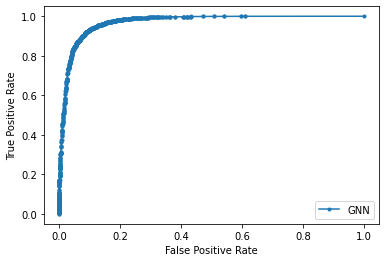

In [ ]:
from matplotlib import pyplot
fpr,tpr,_ = roc_curve(np.array(val_y_list),np.array(logits_list))
roc_auc = auc(fpr, tpr)
print('Test AUC: ' + str(roc_auc))

pyplot.plot(fpr, tpr, marker='.', label='GNN')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()